In [26]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

from tqdm import tqdm

import torchtext
import torch
from torch import nn

from transformers import DistilBertForSequenceClassification, BertForSequenceClassification, DistilBertTokenizer, AdamW, BertTokenizer

%config InlineBackend.figure_format='retina'

In [43]:
# Set params
device = 'cuda'
pretrained_weights = 'bert-base-uncased' # specify type of BERT we want

In [55]:
# load BERT tokenizer and classifier
tokenizer = BertTokenizer.from_pretrained(pretrained_weights)
bert = BertForSequenceClassification.from_pretrained(pretrained_weights)
bert = bert.to(device)

# Load IMDb

In [4]:
# set up fields
TEXT = torchtext.data.Field(
    lower=True, 
    fix_length = 256,
    batch_first=True, 
    truncate_first=True,
    tokenize = tokenizer.tokenize, 
    pad_token=tokenizer.pad_token,
    unk_token=tokenizer.unk_token,
    init_token=tokenizer.cls_token,
    eos_token=tokenizer.sep_token,
)
LABEL = torchtext.data.Field(sequential=False)

In [5]:
# make splits for adversarial set
train_adv, test_adv = torchtext.datasets.IMDB(
    '../data/adversarial_imdb_10k/train',
    TEXT,
    LABEL,
).split(split_ratio=.8, stratified=True)

In [63]:
# take a subset of the adversarial set 
subset_size = 500
train_adv.examples = np.random.choice(train_adv.examples, size=500, replace=False)

In [7]:
# make splits for original set
test = torchtext.datasets.IMDB.splits(TEXT, LABEL, train=None)[0]
test.examples = np.random.choice(test.examples, size=len(test.examples), replace=False).tolist()

In [30]:
# build the vocabulary
TEXT.build_vocab(train_adv)
LABEL.build_vocab(train_adv)

itos = [token for token in tokenizer.vocab]
stoi = {token: index for index, token in enumerate(tokenizer.vocab)}

TEXT.vocab.itos = itos
TEXT.vocab.stoi = defaultdict(lambda: tokenizer.unk_token_id, stoi)

In [31]:
# make iterator for splits
train_adv_iter, test_adv_iter = torchtext.data.BucketIterator.splits(
    (train_adv, test_adv), batch_size=32, device=device)

In [33]:
# make iterator for splits
test_iter = torchtext.data.BucketIterator(test, batch_size=32, device=device, shuffle=False)

# Train BERT

In [45]:
def evaluate(model, eval_iter, max_iter=None):
    """ calculate accuracy over set. max_iter just lets you evaluate on a subset for speed's sake """
    scores = []
    for ibatch, batch in enumerate(eval_iter):
        text = batch.text
        label = batch.label - 1

        output = model(text)[0]
        acc = np.mean((output.argmax(dim=-1) == label).cpu().numpy())
        scores.append(acc)
        
        if max_iter is not None and ibatch > max_iter:
            break
        
    return np.mean(scores)

In [56]:
# # lock all by the last k layers for training
# num_unlocked = 5
# for param in list(bert.parameters())[:-num_unlocked*2]:
#     param.requires_grad = False
# for param in list(bert.parameters())[-num_unlocked*2:]:
#     param.requires_grad = True
[x.requires_grad for x in bert.parameters()][-10:]

[True, True, True, True, True, True, True, True, True, True]

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(bert.parameters(), lr=1e-4)

In [58]:
# keep track of train and validation performance
losses = []
accuracies = []
original_val_accuracies = []
adversarial_val_accuracies = []

In [ ]:
verbose_interval = 20
num_epochs = 20
bert.train()

for epoch in range(num_epochs):
    for ibatch, batch in enumerate(train_adv_iter):
        text = batch.text
        label = batch.label - 1
        
        optimizer.zero_grad()
        output = bert(text)[0]
        acc = torch.mean((output.argmax(dim=-1) == label).float()).item()
        accuracies.append(acc)
        loss = criterion(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
        if (ibatch + 1) % verbose_interval == 0:
            print(epoch+1, ibatch+1,
                  np.mean(losses[-verbose_interval:]),
                  np.mean(accuracies[-verbose_interval:]),
                  sep='\t')
    
    original_val_accuracies.append(evaluate(bert, test_iter, max_iter=100))
    adversarial_val_accuracies.append(evaluate(bert, test_adv_iter))
    
    print(f'adversarial set val. acc: {adversarial_val_accuracies[-1]*100:0.2f}%, original test acc: {original_val_accuracies[-1]*100:0.2f}%')

In [60]:
original_val_accuracies = np.array(original_val_accuracies)
adversarial_val_accuracies = np.array(adversarial_val_accuracies)

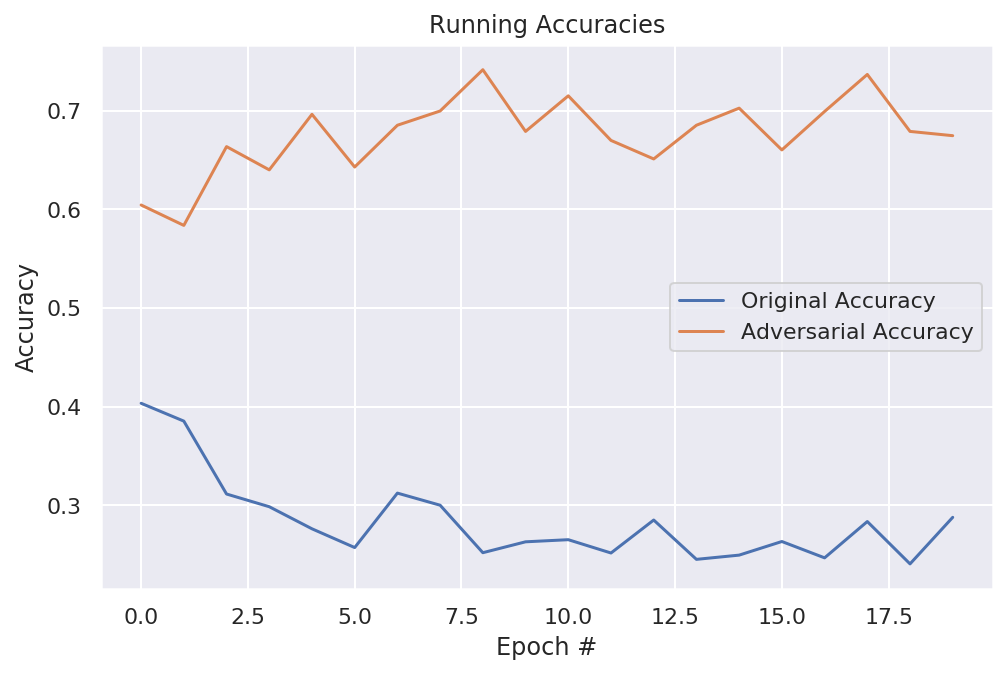

In [61]:
plt.figure(figsize=(8,5))
plt.plot(original_val_accuracies, label='Original Accuracy')
plt.plot(adversarial_val_accuracies, label='Adversarial Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.title('Running Accuracies')
plt.legend()
plt.show()

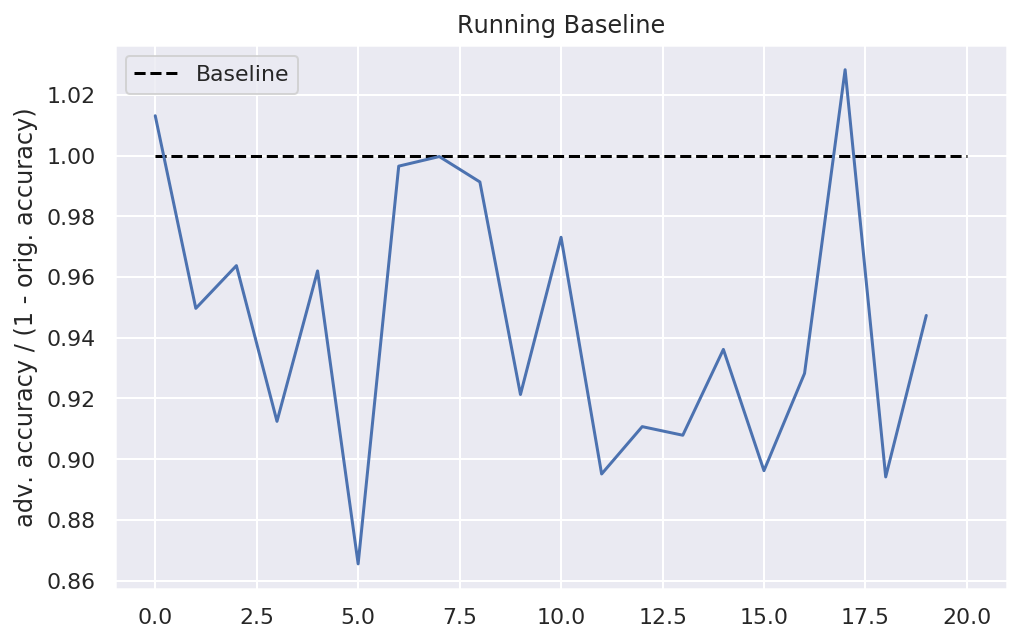

In [62]:
plt.figure(figsize=(8,5))
plt.plot(adversarial_val_accuracies / (1 - original_val_accuracies))
plt.hlines(1, 0, 20, color='black', ls='--', label='Baseline')
plt.title('Running Baseline')
plt.ylabel('adv. accuracy / (1 - orig. accuracy)')
plt.legend()
plt.show()

In [21]:
# np.save(f'{len(train_adv)}.original.npy', original_val_accuracies)
# np.save(f'{len(train_adv)}.adversarial.npy', adversarial_val_accuracies)

In [22]:
evaluate(bert, test_adv_iter)

0.8629807692307692

In [23]:
evaluate(bert, test_iter)

0.15469149616368286